Calculate aerosol mass given the median, min, and max number size distribution parameters.

In [2]:
# 1. Import necessary libraries
import pints
import pints.plot
from pints.io import save_samples
from pints.io import load_samples
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from inv_ccn_utils import * #includes all CCN closure code from Rahul (execute test run, etc. as functions)
import time
#import joypy

In [27]:
# Import observations and parameters
obs_dir = '../input_data'                    

comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data
dp_dry = np.loadtxt(os.path.join(obs_dir,'Dp.txt'))  # Dry particle diameters in nanometers
M_org1_initial = pd.read_csv(os.path.join(obs_dir,'M_org1_initialguess.csv')) # Initial guess for organic mass fraction for mode 1
#nedmead_results = pd.read_csv(os.path.join(obs_dir,'result_nedler_mead_org0p12.csv')) # Results from the Nedler-Mead optimization process
#bimodal_params_range = pd.read_csv(os.path.join(obs_dir,'bimodal_params_range.csv')) # max and min values for bimodal parameters, for uniform prior ranges.

#bimodal_params_old = pd.read_csv(os.path.join(obs_dir, 'Bimodal_parameters.csv'))  # Bimodal parameters for the model
#bimodal_mad = pd.read_csv(os.path.join(obs_dir, 'MAD.csv'), parse_dates=['datetime'])  # Bimodal median absolute deviation

NSD_params_all = pd.read_csv(os.path.join(obs_dir, 'NSD_PARAMS_SCALED.CSV'), parse_dates=['datetime'])  # Load all NSD parameters
CCN_all = pd.read_csv(os.path.join(obs_dir, 'CCN_all.csv'), parse_dates=['datetime','start_time','end_time'])  # Load all CCN obs

#bimodal_params = pd.read_csv(os.path.join(obs_dir, 'bimodal_params_windows.csv'), parse_dates=['datetime'])  # Bimodal parameters for the model

bimodal_params_medians = pd.read_csv(os.path.join(obs_dir, 'bimodal_params_medians.csv'), parse_dates=['datetime'])  # Bimodal parameters for the model


In [10]:
# Extra is a dictionary. First we fill in the constant parameters that are not changing at each iteration.
Extra = make_EXTRA(dp_dry)


In [29]:
# calculate total mass based on median fitted parameters within each window:

total_mass = []
aitken_mass = []
accum_mass = []

#Loop through CCN observation windows:
for i in range(6580):

# Set up ------------------

    # add mass_frac observations to the Extra dictionary:
    mass_frac = [
        comp_obs['Org'][i],         # Mass fractions of the components in the particles: [Org, Other, NH4SO4, NH4NO3, BC].
        comp_obs['total_mass'][i],
        comp_obs['NH4SO4'][i],
        comp_obs['NH4NO3'][i],
        comp_obs['eBC880'][i]
        ]

    # mass vectors:
    mass_vec_NH4SO4 = comp_obs['NH4SO4'][i] * comp_obs['total_mass'][i]
    mass_vec_NH4NO3 = comp_obs['NH4NO3'][i] * comp_obs['total_mass'][i]

    # mass fractions
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

    # densities:
    rho_sulp = Extra['densities'][1]   # in kg/m^3
    rho_nitr = Extra['densities'][2]

    # get inorganic density (we include both NH4SO4 and NH4NO3)
    rho_inorg = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

    # add to Extra the variables that are calculated each time step:
    Extra['true_inputs'] = mass_frac
    Extra['rho_inorg'] = rho_inorg

    NSD1 = size_distribution(np.array([[bimodal_params_medians.loc[i,'NSD1_sum'], bimodal_params_medians.loc[i,'mode1_sigma'], bimodal_params_medians.loc[i,'mode1_d']]]), Extra['dp']) # Aitken mode
    NSD2 = size_distribution(np.array([[bimodal_params_medians.loc[i,'NSD2_sum'], bimodal_params_medians.loc[i,'mode2_sigma'], bimodal_params_medians.loc[i,'mode2_d']]]), Extra['dp']) # Accumulation mode

    # calculate the mass of the particles in both modes:
    info_mass = cal_mass(Extra['dp'], Extra['true_inputs'], Extra, NSD1[1], NSD2[1])

    # get initial mass fractions for both modes:
    initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
    initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
    tot_mass_org = info_mass['tot_org']
    tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
    initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
    initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode

    # Mass fractions for black carbon
    f_BC1 = initial_M_BC1 / initial_tot_ait_mass
    f_BC2 = initial_M_BC2 / initial_tot_acc_mass

    # Calculate remaining mass in each mode
    M_org1=M_org1_initial['M_org1'][i]
    M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
    M_org2 = tot_mass_org - M_org1 #organics mass in mode2
    M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
    total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
    total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

    total_mass.append(total_ait_mass + total_acc_mass)  # Total mass in both modes
    aitken_mass.append(total_ait_mass)  # Mass in Aitken mode
    accum_mass.append(total_acc_mass)  # Mass in Accumulation mode


In [32]:
# Save dataframe:

df_total_mass = pd.DataFrame({
    'datetime': bimodal_params_medians['datetime'],
    'total_mass': total_mass,
    'aitken_mass': aitken_mass,
    'accum_mass': accum_mass
})

# Save the dataframe to a CSV file
df_total_mass.to_csv(os.path.join(obs_dir, 'total_mass_median_NSDparams.csv'), index=False)

In [ ]:
# calculate the total mass for each aerosol observation within each CCN window

NSD_params_highres = pd.read_csv(os.path.join(obs_dir, 'NSD_params_withwindows.csv'), parse_dates=['datetime'])  # Load all NSD parameters

total_mass_highres = []
aitken_mass_highres = []
accum_mass_highres = []

#Loop through CCN observations:
for j in range(len(NSD_params_highres)):

    i = NSD_params_highres.loc[j,'window_id'] # index of the CCN window

    # add mass_frac observations to the Extra dictionary:
    mass_frac = [
        comp_obs['Org'][i],         # Mass fractions of the components in the particles: [Org, Other, NH4SO4, NH4NO3, BC].
        comp_obs['total_mass'][i],
        comp_obs['NH4SO4'][i],
        comp_obs['NH4NO3'][i],
        comp_obs['eBC880'][i]
        ]

    # mass vectors:
    mass_vec_NH4SO4 = comp_obs['NH4SO4'][i] * comp_obs['total_mass'][i]
    mass_vec_NH4NO3 = comp_obs['NH4NO3'][i] * comp_obs['total_mass'][i]

    # mass fractions
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

    # densities:
    rho_sulp = Extra['densities'][1]   # in kg/m^3
    rho_nitr = Extra['densities'][2]

    # get inorganic density (we include both NH4SO4 and NH4NO3)
    rho_inorg = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

    # add to Extra the variables that are calculated each time step:
    Extra['true_inputs'] = mass_frac
    Extra['rho_inorg'] = rho_inorg

    # calculate size distributions:

    NSD1_highrest = size_distribution(np.array([[NSD_params_highres.loc[j,'NSD1_sum'], NSD_params_highres.loc[j,'mode1_sigma'], NSD_params_highres.loc[j,'mode1_d']]]), Extra['dp']) # Aitken mode
    NSD2_highrest = size_distribution(np.array([[NSD_params_highres.loc[j,'NSD2_sum'], NSD_params_highres.loc[j,'mode2_sigma'], NSD_params_highres.loc[j,'mode2_d']]]), Extra['dp']) # Accumulation mode

    NSD1_vec = NSD1_highrest[1]
    NSD2_vec = NSD2_highrest[1]

    # calculate the mass of the particles in both modes:
    info_mass = cal_mass(Extra['dp'], Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)

    # get initial mass fractions for both modes:
    initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
    initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
    tot_mass_org = info_mass['tot_org']
    tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
    initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
    initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode

    # Mass fractions for black carbon
    f_BC1 = initial_M_BC1 / initial_tot_ait_mass
    f_BC2 = initial_M_BC2 / initial_tot_acc_mass

    # Calculate remaining mass in each mode
    M_org1=M_org1_initial['M_org1'][i]
    M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
    M_org2 = tot_mass_org - M_org1 #organics mass in mode2
    M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
    total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
    total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

    aitken_mass_highres.append(total_ait_mass)
    accum_mass_highres.append(total_acc_mass)
    total_mass_highres.append(total_ait_mass + total_acc_mass)
           


In [21]:
mass_df_highres = pd.DataFrame({
    'datetime': NSD_params_highres['datetime'],
    'window_id': NSD_params_highres['window_id'],
    'total mass (ug/m3)': total_mass_highres,
    'Aitken mass (ug/m3)': aitken_mass_highres,
    'Accumulation mass (ug/m3)': accum_mass_highres
})

In [22]:
mass_df_highres

,datetime,window_id,total mass (ug/m3),Aitken mass (ug/m3),Accumulation mass (ug/m3)
0,2016-08-16 09:00:00,0,3.947072,0.111055,3.836017
1,2016-08-16 09:00:00,0,3.859889,0.081763,3.778125
2,2016-08-16 09:00:00,0,3.715135,0.132123,3.583011
3,2016-08-16 09:00:00,0,3.685609,0.088317,3.597292
4,2016-08-16 09:00:00,0,3.678390,0.056608,3.621782
...,...,...,...,...,...
54360,2020-04-01 21:00:00,6579,2.253202,0.084847,2.168355
54361,2020-04-01 21:00:00,6579,2.116711,0.079339,2.037372
54362,2020-04-01 21:00:00,6579,2.149173,0.078937,2.070236
54363,2020-04-01 21:00:00,6579,0.454338,0.073656,0.380683


In [23]:
NSD_params_highres

,Unnamed: 0,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum,CCN_window,window_id
0,0,2016-08-16 09:00:00,54.537796,1.75,204.820193,200.00000,1.750000,163.407993,198.005175,153.393952,0.0,0
1,1,2016-08-16 09:00:00,49.252045,1.75,189.778383,195.45042,1.750000,171.390136,197.899104,160.658735,0.0,0
2,2,2016-08-16 09:00:00,56.746544,1.75,206.566825,195.45042,1.750000,161.320898,209.134418,152.361834,0.0,0
3,3,2016-08-16 09:00:00,54.537796,1.75,157.271650,200.00000,1.750000,153.624102,157.465118,143.847847,0.0,0
4,4,2016-08-16 09:00:00,49.252045,1.75,143.007878,195.45042,1.750000,165.181851,137.013872,154.010494,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54360,54363,2020-04-01 21:00:00,18.273353,1.75,4318.001361,195.45042,1.750000,89.899684,4040.338426,92.699741,11735.0,6579
54361,54364,2020-04-01 21:00:00,18.273353,1.75,4170.370307,195.45042,1.750000,84.860817,3778.042978,87.100047,11735.0,6579
54362,54365,2020-04-01 21:00:00,18.273353,1.75,4136.599234,195.45042,1.750000,85.660015,3758.886858,88.505038,11735.0,6579
54363,54366,2020-04-01 21:00:00,20.445895,1.60,3682.118934,144.76132,1.333333,96.046168,3792.723555,103.049674,11735.0,6579


In [26]:
NSD_params_all

,datetime,mode1_d,mode1_sigma,mode1_n,mode2_d,mode2_sigma,mode2_n,NSD1_sum,NSD2_sum
0,2016-01-01 00:00:01,24.257639,1.75,598.600795,113.426747,1.75,754.493168,608.788000,777.058013
1,2016-01-01 00:10:00,24.591691,1.75,519.577642,111.437410,1.75,722.740761,518.452691,749.432131
2,2016-01-01 00:20:01,20.970392,1.75,537.384887,105.106872,1.75,742.394200,555.462528,785.728693
3,2016-01-01 00:30:00,24.591691,1.75,593.498833,111.437410,1.75,684.603631,598.729273,711.487335
4,2016-01-01 00:40:01,32.201702,1.75,777.666797,129.955828,1.75,590.103240,832.767204,585.891258
...,...,...,...,...,...,...,...,...,...
168100,2020-12-31 22:50:00,75.330302,1.75,391.141800,223.932377,1.75,50.060356,406.692976,45.771160
168101,2020-12-31 23:00:00,65.381452,1.75,361.936465,170.591083,1.75,102.089841,402.636874,99.342258
168102,2020-12-31 23:10:00,65.381452,1.75,355.440467,170.591083,1.75,110.026332,400.580431,105.183563
168103,2020-12-31 23:20:00,63.955725,1.75,367.152082,167.814816,1.75,103.879694,390.774734,100.053038


In [ ]:
# save some dataframes:

mass_from_median_NSD = pd.DataFrame({
    'total mass (ug/m3)': total_mass_medianvalues,
    'datetime': bimodal_params['datetime'],
})

#mass_from_median_NSD.to_csv('mass_from_median_NSDparams.csv', index=False)

mass_highres_range = pd.DataFrame({
    'min mass (ug/m3)': mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].min(),
    'max mass (ug/m3)': mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].max(),
    'datetime': bimodal_params['datetime'],
})

#mass_highres_range.to_csv('mass_highres_range.csv', index=False)

Text(37.597222222222214, 0.5, 'total mass using bimodal_params (ug/m3)')

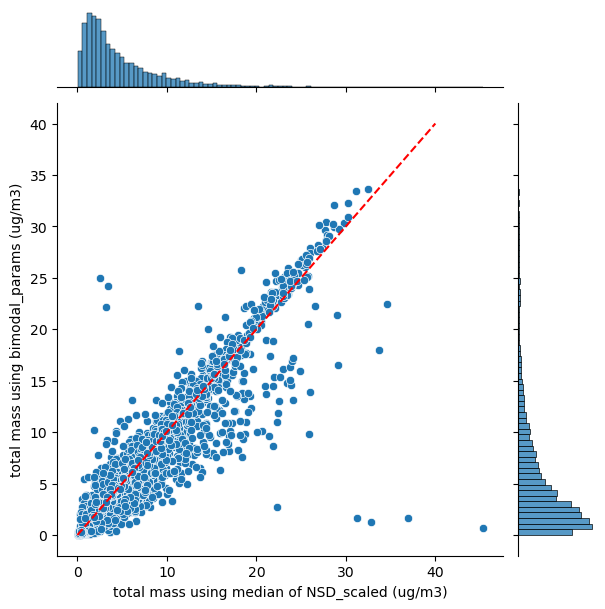

In [20]:
g = sns.jointplot(x=total_mass_medianvalues, y=total_mass_old, kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')
plt.xlabel('total mass using median of NSD_scaled (ug/m3)')
plt.ylabel('total mass using bimodal_params (ug/m3)')

In [21]:
mass_df = pd.DataFrame({
    'calculated total mass (ug/m3)': total_mass_medianvalues + total_mass_old,
    'method': ['median of NSD_scaled']*len(total_mass_medianvalues) + ['bimodal_params.csv']*len(total_mass_old),
    'observed total mass (ug/m3)': comp_obs['total_mass'].values.tolist() + comp_obs['total_mass'].values.tolist()
})

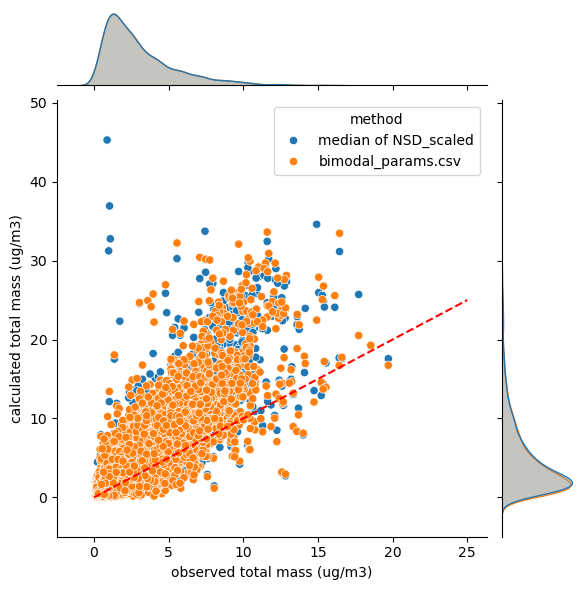

In [22]:
g = sns.jointplot(mass_df, x='observed total mass (ug/m3)', y='calculated total mass (ug/m3)', hue='method', kind='scatter')
g.ax_joint.plot([0,25], [0,25], color='red', linestyle='--')

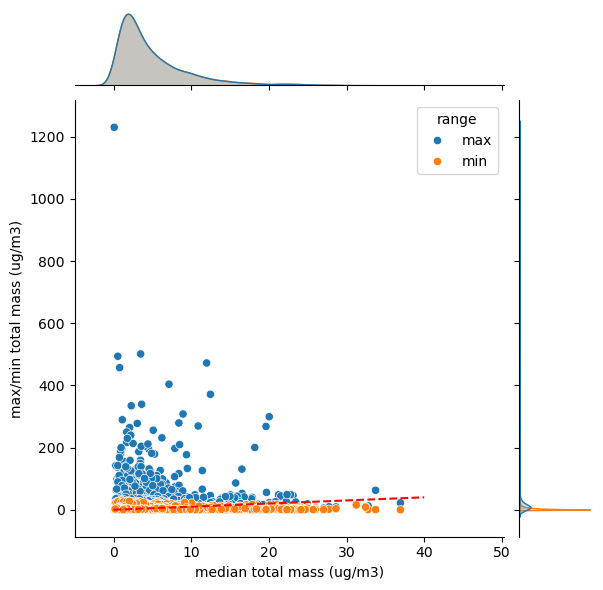

In [23]:
mass_range_df = pd.DataFrame({
    'max/min total mass (ug/m3)': total_mass_maxvalues + total_mass_minvalues,
    'range': ['max']*len(total_mass_maxvalues) + ['min']*len(total_mass_minvalues),
    'median total mass (ug/m3)': total_mass_medianvalues + total_mass_medianvalues
})
g = sns.jointplot(mass_range_df, x='median total mass (ug/m3)', y='max/min total mass (ug/m3)', hue='range', kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')

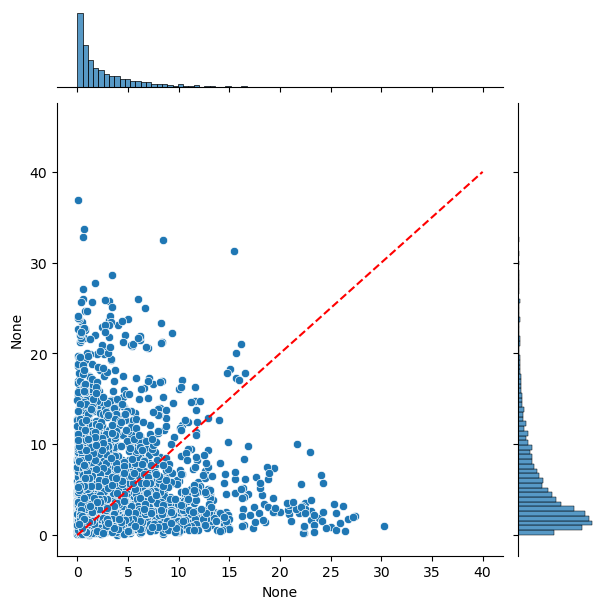

In [24]:
g = sns.jointplot(x=total_mass_minvalues, y=total_mass_medianvalues, kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')

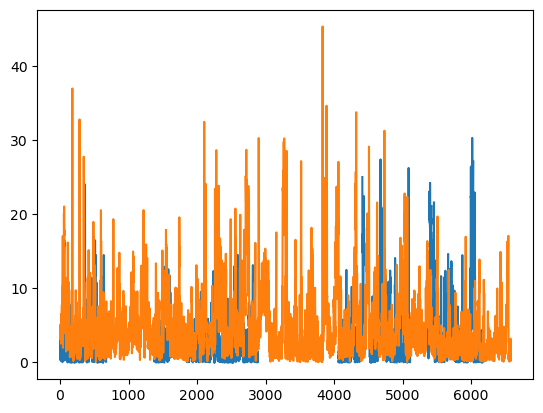

In [22]:
plt.plot(total_mass_minvalues)
plt.plot(total_mass_medianvalues)

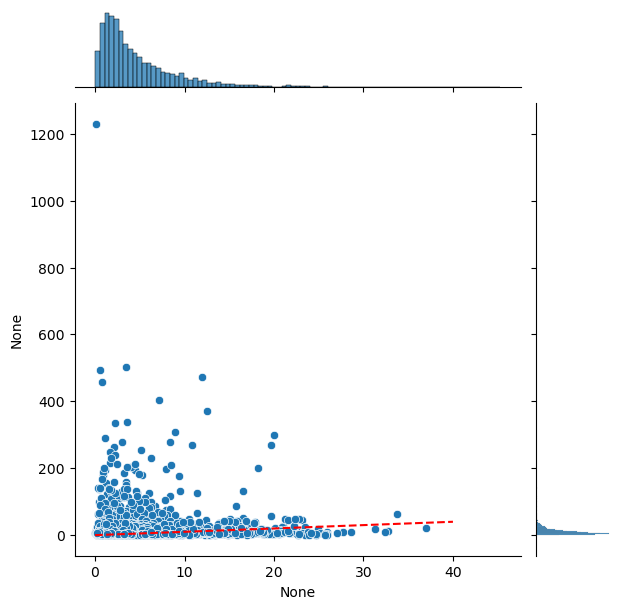

In [11]:
g = sns.jointplot(x=total_mass_medianvalues, y=total_mass_maxvalues, kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')

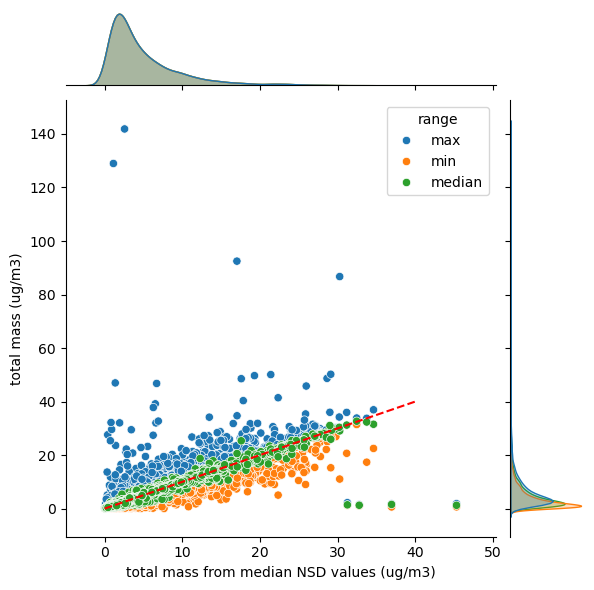

In [8]:
mass_highres_range_df = pd.DataFrame({
    'total mass (ug/m3)': mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].max().values.tolist() + mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].min().values.tolist() + mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].median().values.tolist(),
    'range': ['max']*6580 + ['min']*6580 + ['median']*6580,
    'total mass from median NSD values (ug/m3)': total_mass_medianvalues + total_mass_medianvalues + total_mass_medianvalues
})
g = sns.jointplot(mass_highres_range_df, x='total mass from median NSD values (ug/m3)', y='total mass (ug/m3)', hue='range', kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')

Text(0.5, 36.72222222222221, 'total mass of median parameters (ug/m3)')

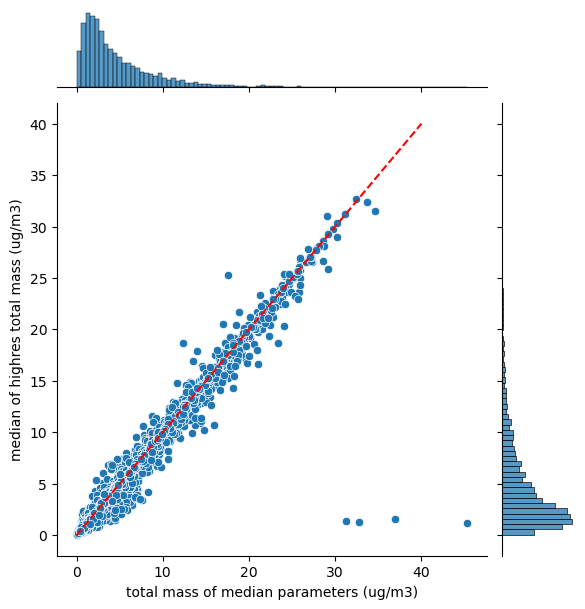

In [9]:
g = sns.jointplot(x=total_mass_medianvalues, y=mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].median(), kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')
plt.ylabel('median of highres total mass (ug/m3)')
plt.xlabel('total mass of median parameters (ug/m3)')

Text(0.5, 36.72222222222221, 'total mass of max parameters (ug/m3)')

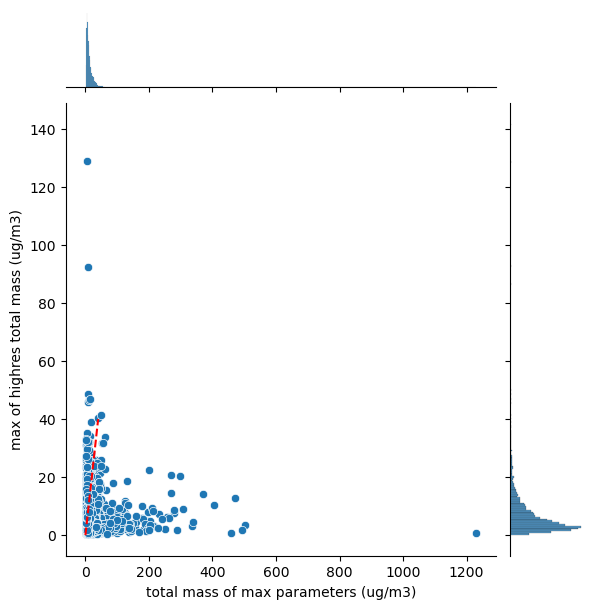

In [10]:
g = sns.jointplot(x=total_mass_maxvalues, y=mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].max(), kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')
plt.ylabel('max of highres total mass (ug/m3)')
plt.xlabel('total mass of max parameters (ug/m3)')

Text(0.5, 36.72222222222221, 'min of highres total mass (ug/m3)')

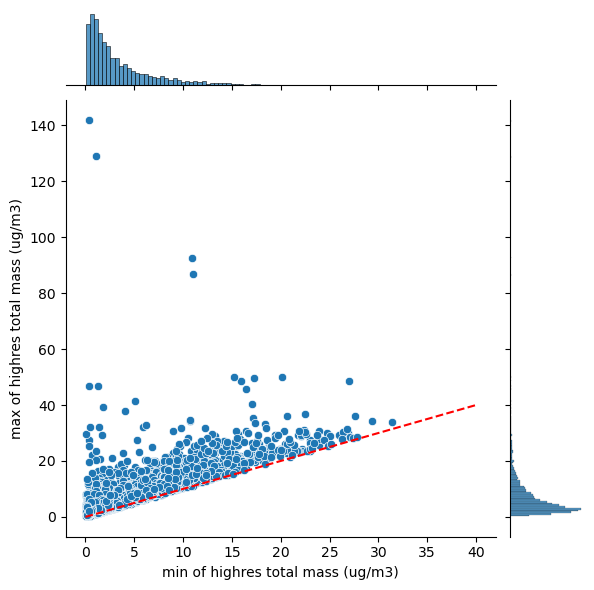

In [15]:
g = sns.jointplot(x=mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].min(), y=mass_df_highres.groupby('window_id')['calculated total mass (ug/m3)'].max(), kind='scatter')
g.ax_joint.plot([0,40], [0,40], color='red', linestyle='--')
plt.ylabel('max of highres total mass (ug/m3)')
plt.xlabel('min of highres total mass (ug/m3)')

In [32]:
mass_df_highres

,calculated total mass (ug/m3),window_id
0,3.947072,0
1,3.859889,0
2,3.715135,0
3,3.685609,0
4,3.678390,0
...,...,...
54360,2.253202,6579
54361,2.116711,6579
54362,2.149173,6579
54363,0.454338,6579


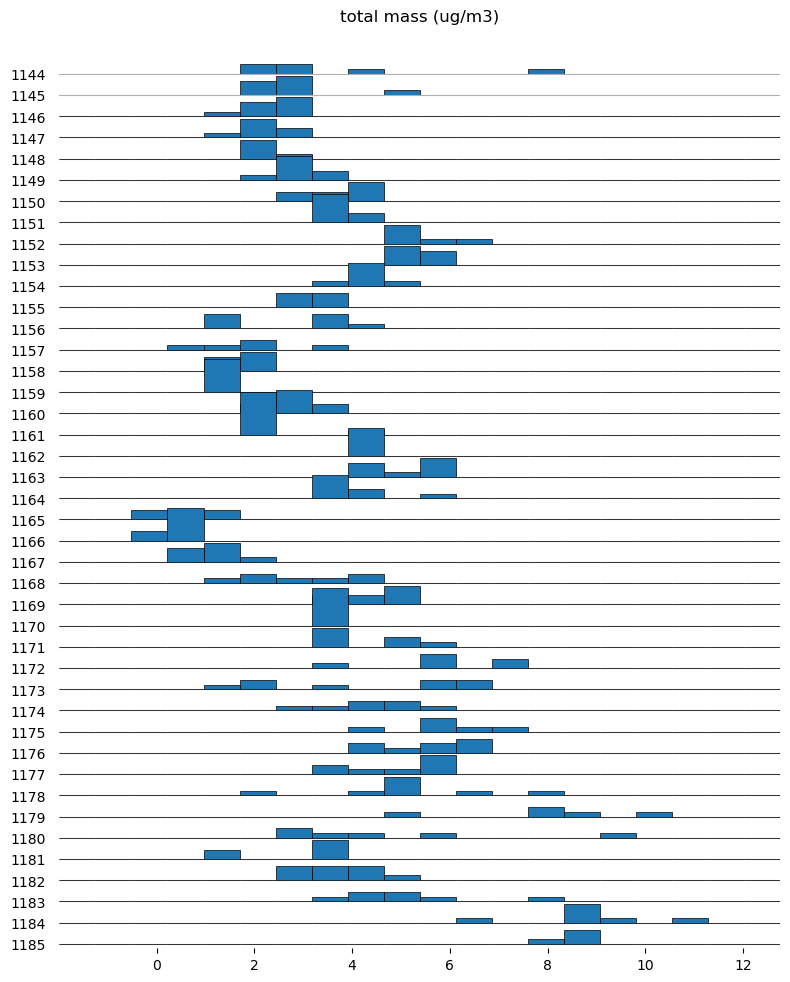

In [33]:
plt_idx1 = 10000
plt_idx2 = 10300

#days_list = filtered_NSD_params[plt_idx1:plt_idx2].drop_duplicates('CCN_window')['datetime'].dt.to_period('D').astype(str).tolist()
#seen = set()
#labels = []

#param_idx = filtered_NSD_params[plt_idx1:plt_idx2].drop_duplicates('CCN_window')['CCN_window'].values

#for val in days_list:
#    if val not in seen:
#        labels.append(val)
#        seen.add(val)
#    else:
#        labels.append(None)

f, axs = joypy.joyplot(
    data=mass_df_highres[plt_idx1:plt_idx2],
    by='window_id',
    column='calculated total mass (ug/m3)',
    range_style='own',
    #x_range = (-10,1500),
    grid='y',
    linewidth=0.5,
    legend=False,
    hist=True,
    #kind='counts',
    bins=20,
    overlap=0.5,
    figsize=(8,10),
    title='total mass (ug/m3)',
)

#for i in range(len(axs)-1):
#    d = bimodal_params.loc[param_idx[i]]['mode2_d']
#    #yval = axs[i].get_ydata().max()
#    axs[i].plot([d,d],[0,3], color='red', zorder=200)